In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

history_path = "/content/drive/MyDrive/MGU_dane/Resnet/history"
model_path = "./saved_model/resnet50"

In [2]:
#%tensorflow_version 1.x
#!pip install 'h5py==2.10.0' --force-reinstall

#try:
  # ustaw wersję tensorflow na 1
#  %tensorflow_version 1.x
#except Exception:
#  pass

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
# tf.disable_v2_behavior()
import numpy as np
# from setup_cifar import CIFAR, CIFARModel
# from l2_attack import CarliniL2
import matplotlib.pyplot as plt
from random import random
from tensorflow.keras.applications.resnet50 import ResNet50
# import tensorflow_datasets as tfds
import os, re, time, json
from pathlib import Path

print("Tensorflow version " + tf.__version__)

BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

2022-01-21 15:46:39.794599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-21 15:46:39.794657: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.7.0


In [3]:
## l2_attack.py -- attack a network optimizing for l_2 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import sys
#tf.disable_v2_behavior()
import numpy as np

BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class CarliniL2:
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 binary_search_steps = BINARY_SEARCH_STEPS, max_iterations = MAX_ITERATIONS,
                 abort_early = ABORT_EARLY, 
                 initial_const = INITIAL_CONST,
                 boxmin = -0.5, boxmax = 0.5):
        """
        The L_2 optimized attack. 

        This attack is the most efficient and should be used as the primary 
        attack to evaluate potential defenses.

        Returns adversarial examples for the supplied model.

        confidence: Confidence of adversarial examples: higher produces examples
          that are farther away, but more strongly classified as adversarial.
        batch_size: Number of attacks to run simultaneously.
        targeted: True if we should perform a targetted attack, False otherwise.
        learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        binary_search_steps: The number of times we perform binary search to
          find the optimal tradeoff-constant between distance and confidence. 
        max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        abort_early: If true, allows early aborts if gradient descent gets stuck.
        initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. If binary_search_steps is large,
          the initial constant is not important.
        boxmin: Minimum pixel value (default -0.5).
        boxmax: Maximum pixel value (default 0.5).
        """

        image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

        shape = (batch_size,image_size,image_size,num_channels)
        
        # the variable we're going to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        # these are variables to be more efficient in sending data to tf
        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)

        # and here's what we use to assign them
        self.assign_timg = tf.placeholder(tf.float32, shape)
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))
        self.assign_const = tf.placeholder(tf.float32, [batch_size])
        
        # the resulting image, tanh'd to keep bounded from boxmin to boxmax
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus
        
        # prediction BEFORE-SOFTMAX of the model
        print("self.newimg", self.newimg.shape)
        self.output = model.predict(self.newimg)
        
        # distance to the input data
        self.l2dist = tf.reduce_sum(tf.square(self.newimg-(tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other-real+self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real-other+self.CONFIDENCE)

        # sum up the losses
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1+self.loss2
        
        # Setup the adam optimizer and keep track of variables we're creating
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        # these are the variables to initialize when we run
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    def attack(self, imgs, targets):
        """
        Perform the L_2 attack on the given images for the given targets.

        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

    def attack_batch(self, imgs, labs):
        """
        Run the attack on a batch of images and labels.
        """
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y

        batch_size = self.batch_size

        # convert to tanh-space
        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # the best l2, score, and image attack
        o_bestl2 = [1e10]*batch_size
        o_bestscore = [-1]*batch_size
        o_bestattack = [np.zeros(imgs[0].shape)]*batch_size
        
        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print(o_bestl2)
            # completely reset adam's internal state.
            self.sess.run(self.init)
            batch = imgs[:batch_size]
            batchlab = labs[:batch_size]
    
            bestl2 = [1e10]*batch_size
            bestscore = [-1]*batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = np.inf
            for iteration in range(self.MAX_ITERATIONS):
                # perform the attack 
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss, 
                                                         self.l2dist, self.output, 
                                                         self.newimg])

                if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                
                # print out the losses every 10%
                if iteration%(self.MAX_ITERATIONS//10) == 0:
                    print(iteration,self.sess.run((self.loss,self.loss1,self.loss2)))

                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e,(l2,sc,ii) in enumerate(zip(l2s,scores,nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack


In [4]:
"""
Fragment do wizualizacji zawartości zbioru danych CIFAR
Źródło: https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner
"""

#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [5]:
# Załadowanie zbioru danych CIFAR

(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

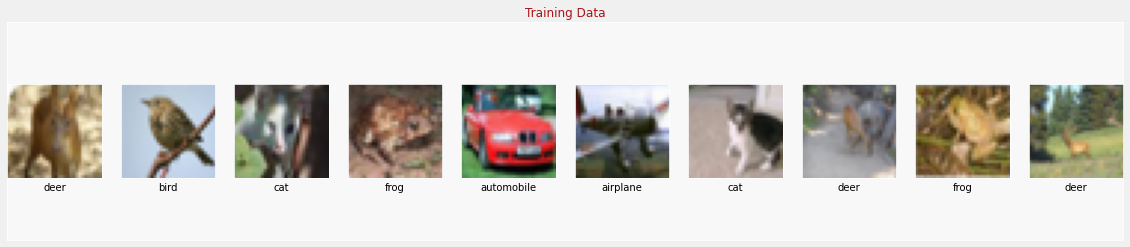

In [6]:
# Wyświetlenie danych CIFAR

display_images(training_images, training_labels, training_labels, "Training Data" )

In [7]:
# Normalizacja danych wejściowych

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

print(valid_X.shape)

(10000, 32, 32, 3)


In [8]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model

model = None

my_file = Path(model_path)
if not my_file.is_file():
  model = define_compile_model()

  model.summary()

In [12]:
# Trenowanie modelu

EPOCHS = 3

history = []

def save_history(history):
  json.dump(history, open(history_path, 'w'))

my_file = Path(model_path)
if my_file.is_file():
  # file exists

  model = tf.keras.models.load_model(model_path)
  #model.run_eagerly = True

  # Check its architecture
  model.summary()

  # history = json.load(open(history_path, 'r'))

else:

  history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)
  !mkdir -p saved_model
  model.save(model_path)
  print(history.history)

  # save_history(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [13]:
valid_X.shape

(10000, 32, 32, 3)

In [14]:
loss, accuracy = model.evaluate(valid_X[:1000], validation_labels[:1000], batch_size=64)

# wymaga danych 'history'

#plot_metrics("loss", "Loss")

#plot_metrics("acc", "Accuracy")

/home/piotrek/PycharmProjects/nn_robust_attacks/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


/home/piotrek/PycharmProjects/nn_robust_attacks/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


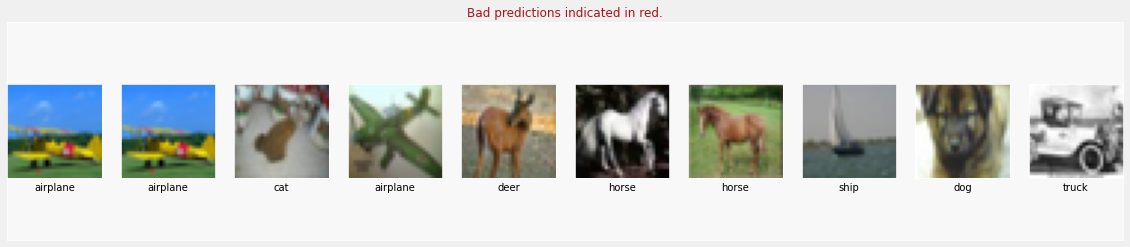

In [15]:
# Predykcje

probabilities = model.predict(valid_X[:100], batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")

In [16]:
# CW ATTACK

class Resnet50Model_CW:
    def __init__(self, resnet_model):
        self.num_channels = 3
        self.image_size = 32
        self.num_labels = 10
        self.model = resnet_model

    def predict(self, input_data):
        return self.model.predict(input_data, batch_size=64, steps=1)

cl2_model = Resnet50Model_CW(model)

with tf.Session() as sess:
    attack = CarliniL2(sess, cl2_model, batch_size=9, max_iterations=1000, confidence=0)

    adv = attack.attack(valid_X, validation_labels)

    display_images(adv, probabilities, validation_labels, "Bad predictions indicated in red.")

self.newimg (9, 32, 32, 3)


FailedPreconditionError: Could not find variable classification_1/bias. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/classification_1/bias)
	 [[{{node classification_1/BiasAdd/ReadVariableOp}}]]